In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [3]:
df = pd.read_csv('–¥–ª—è –º–æ–¥–µ–ª–∏ v6.csv', parse_dates=['report_date'])

In [ ]:
target_ = 'target_area'

In [4]:
cat = df.copy()
cat.shape
# –æ—Å—Ç–∞–≤–ª—è–µ–º —Å –Ω–µ–ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ —Ç–∞—Ä–≥–µ—Ç–æ–º
cat=cat[cat[target_].notnull()]
cat.shape[0]

7100

In [5]:
def split_train_oot(data):
    # –ù–∞—Ö–æ–¥–∏–º —Å–∞–º—É—é –ø–æ–∑–¥–Ω—é—é –¥–∞—Ç—É –≤ –¥–∞–Ω–Ω—ã—Ö
    latest_date = data['report_date'].max()

    # –í—ã—á–∏—Å–ª—è–µ–º –¥–∞—Ç—É, –∫–æ—Ç–æ—Ä–∞—è –±—ã–ª–∞ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞ –Ω–∞–∑–∞–¥ –æ—Ç —Å–∞–º–æ–π –ø–æ–∑–¥–Ω–µ–π –¥–∞—Ç—ã
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # –û—Ç–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ report_date –ø–æ–ø–∞–¥–∞–µ—Ç –≤ –ø–æ—Å–ª–µ–¥–Ω–∏–µ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # –¢–µ–ø–µ—Ä—å –∑–∞–ø–æ–ª–Ω–∏–º NaN –∑–Ω–∞—á–µ–Ω–∏—è –≤ —Å—Ç–æ–ª–±—Ü–µ 'split_type' –∑–Ω–∞—á–µ–Ω–∏–µ–º 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [6]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –≤—Å–µ—Ö –º–µ—Ç—Ä–∏–∫
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [7]:
def shap_gr(name_model, values):# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É —Å —Ä–µ–≥—É–ª–∏—Ä—É–µ–º—ã–º –º–µ—Å—Ç–æ–º –¥–ª—è —à–∫–∞–ª—ã
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≥—Ä–∞—Ñ–∏–∫–∞
    ax1.set_title("–í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ SHAP –∑–Ω–∞—á–µ–Ω–∏—è–º", fontsize=14, pad=20)
    ax1.set_xlabel("–í–ª–∏—è–Ω–∏–µ –Ω–∞ –≤—ã—Ö–æ–¥ –º–æ–¥–µ–ª–∏ (SHAP value)", fontsize=12)
    ax1.set_ylabel("–ü—Ä–∏–∑–Ω–∞–∫–∏", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [8]:
cat = split_train_oot(cat)

# –ú–æ–¥–µ–ª—å

# –¢–µ—Å—Ç 1

In [9]:
# cat =  cat.sort_values(by='report_date')# —Å–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –ø–æ –¥–∞—Ç–µ –ø–µ—Ä–µ–¥ –æ–±—É—á–µ–Ω–∏–µ–º
cat['year'] = cat['report_date'].dt.year
cat['month'] = cat['report_date'].dt.month
cat['quarter'] = cat['report_date'].dt.quarter
cat.drop('report_date', axis=1, inplace=True)

In [10]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date'
] + target_


In [11]:
# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ –æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.1,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_base = metrics_df

In [12]:
metrics_df_base

dataset         MAE            MSE        RMSE      MAPE      WAPE  \
0   train   34.759269    8201.279834   90.560918  0.112690  0.066575   
1    test  230.577459  114544.673654  338.444491  1.587632  0.742579   

         R2  mean_target   mean_pred  n_samples  
0  0.972402   522.109088  508.796277       5961  
1  0.020535   310.508982  463.019817       1139

# –û—Ç–±–æ—Ä —Ñ–∏—á

In [13]:
cat = df.copy()
cat.shape
# –æ—Å—Ç–∞–≤–ª—è–µ–º —Å –Ω–µ–ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ —Ç–∞—Ä–≥–µ—Ç–æ–º
cat=cat[cat[target_].notnull()]
cat.shape[0]

7100

In [14]:
cat = split_train_oot(cat)

In [15]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –≤—Ä–µ–º–µ–Ω–∏ –≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# –°–ø–∏—Å–æ–∫ –¥–ª—è —Å–±–æ—Ä–∞ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö —Ñ–∏—á –∏ –º–µ—Ç—Ä–∏–∫
features_across_splits = []
metrics_across_splits = []

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –¥–∞—Ç–µ –¥–ª—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–≥–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\nüîπ –°–ø–ª–∏—Ç {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # –°–æ–∑–¥–∞–Ω–∏–µ Pool –æ–±—ä–µ–∫—Ç–æ–≤
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
    model.fit(train_pool, eval_set=val_pool)
    
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏ –º–µ—Ç—Ä–∏–∫–∏
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –¥–ª—è train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫ –¥–ª—è validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # –û—Ç–±–æ—Ä —Ñ–∏—á–µ–π
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" –û—Ç–æ–±—Ä–∞–Ω–æ —Ñ–∏—á–µ–π: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame(metrics_across_splits)

# –§–æ—Ä–º–∞—Ç–∏—Ä—É–µ–º –¥–∞—Ç—ã 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# –ü–µ—Ä–µ—É–ø–æ—Ä—è–¥–æ—á–∏–≤–∞–µ–º —Å—Ç–æ–ª–±—Ü—ã
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# –ê–Ω–∞–ª–∏–∑ —Ñ–∏—á–µ–π
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n –ò—Ç–æ–≥–æ–≤—ã–µ —É—Å—Ç–æ–π—á–∏–≤—ã–µ —Ñ–∏—á–∏ (–≤—Å—Ç—Ä–µ—á–∞–ª–∏—Å—å >= 2 —Ä–∞–∑):")
print("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ:", len(final_features))



üîπ –°–ø–ª–∏—Ç 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 213.9495745
bestIteration = 123

Shrink model to first 124 iterations.
Feature #35 eliminated
Feature #102 eliminated
Feature #25 eliminated
Feature #28 eliminated
Feature #855 eliminated
Feature #331 eliminated
Feature #50 eliminated
Feature #752 eliminated
Feature #645 eliminated
Feature #245 eliminated
Feature #788 eliminated
Feature #529 eliminated
Feature #244 eliminated
Feature #8 eliminated
Feature #600 eliminated
Feature #608 eliminated
Feature #1048 eliminated
Feature #661 eliminated
Feature #730 eliminated
Feature #654 eliminated
Feature #1042 eliminated
Feature #513 eliminated
Feature #20 eliminated
Feature #191 eliminated
Feature #585 eliminated
Feature #54 eliminated
Feature #430 eliminated
Feature #34 eliminated
Feature #156 eliminated
Feature #986 eliminated
Feature #782 eliminated
Feature #734 eliminated
Feature #315 elimina

In [16]:
metrics_df_select_features

split  start_date    end_date  n_samples  mean_target   mean_pred  \
0  fold_1_train  2022-03-01  2022-09-01        996   588.572450  541.495396   
1    fold_1_val  2022-09-01  2023-03-01        993   469.433515  476.272066   
2  fold_2_train  2022-03-01  2023-03-01       1989   529.092831  501.098459   
3    fold_2_val  2023-03-01  2023-08-01        993   461.282759  447.251508   
4  fold_3_train  2022-03-01  2023-08-01       2982   506.512213  478.215655   
5    fold_3_val  2023-08-01  2023-12-01        993   640.243868  543.421088   
6  fold_4_train  2022-03-01  2023-12-01       3975   539.919895  449.842225   
7    fold_4_val  2023-12-01  2024-03-01        993   448.587966  511.781988   
8  fold_5_train  2022-03-01  2024-03-01       4968   521.664539  492.451589   
9    fold_5_val  2024-03-01  2024-06-01        993   524.333173  401.416120   

          mae        rmse      mape      wape        r2  
0  120.730344  235.284215  0.345784  0.205124  0.846972  
1  212.045662  317.627626  0.903592  0.451705  0.529644  
2   61.663929  154.578867  0.176672  0.116547  0.918108  
3  188.210765  284.029646  0.917607  0.408016  0.640836  
4   72.410705  166.103960  0.228077  0.142959  0.897978  
5  232.253933  362.846090  0.762951  0.362759  0.708634  
6  213.423755  382.112413  0.779935  0.395288  0.542447  
7  238.223483  355.192988  1.322749  0.531052  0.470090  
8   90.163422  184.382144  0.291253  0.172838  0.888260  
9  213.614413  334.595386  0.595311  0.407402  0.572330

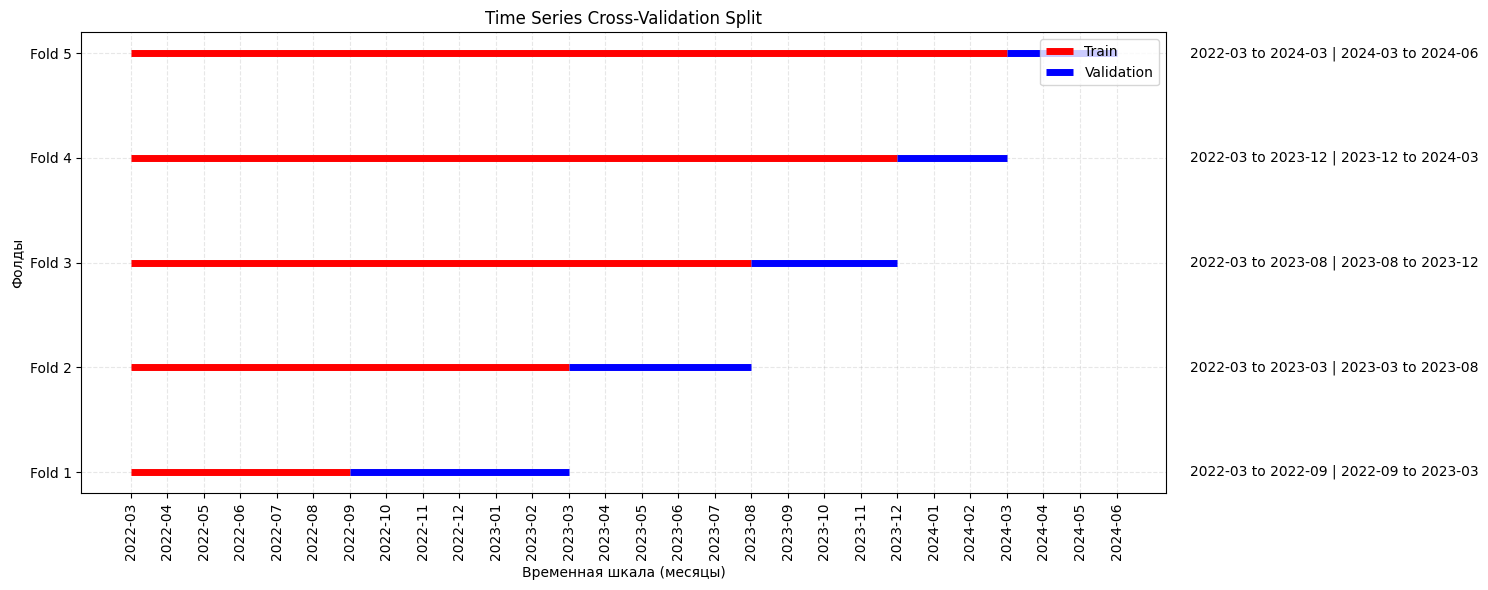

In [21]:
plt.figure(figsize=(15, 6))

# –ü–æ–ª—É—á–∞–µ–º –≤—Å–µ —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –¥–∞—Ç—ã
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # –§–æ—Ä–º–∞—Ç YYYY-MM

# –¶–≤–µ—Ç–∞ –¥–ª—è train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # –ù–∞—Ö–æ–¥–∏–º –∏–Ω–¥–µ–∫—Å—ã –¥–∞—Ç
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # –†–∏—Å—É–µ–º –ª–∏–Ω–∏–∏
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('–í—Ä–µ–º–µ–Ω–Ω–∞—è —à–∫–∞–ª–∞ (–º–µ—Å—è—Ü—ã)')
plt.ylabel('–§–æ–ª–¥—ã')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# –î–æ–±–∞–≤–∏–º –ø–æ–¥–ø–∏—Å–∏ –¥–∞—Ç –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ñ–æ–ª–¥–∞
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [18]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

area__g_building__smt_projected_total_area__rooms_2__sum  \
11                                          14610.101          
12                                          14610.101          
13                                          14610.101          

    expon_cost__g_building__pc_cost__day_5__avg__1M  \
11                                        189968.00   
12                                        189968.00   
13                                        174418.05   

    price__g_building__rooms_0__sum__1M  \
11                          667908500.0   
12                          689522750.0   
13                          627455360.0   

    reservations__g_building__smt_projected_total_area__long_reservation__sum__6M  \
11                                                NaN                               
12                                                NaN                               
13                                              149.8                               

    balance__g_building__rooms_3plus__sum  \
11                                16826.0   
12                                16648.4   
13                                16132.5   

    area__g_building__smt_projected_total_area__reservation_end_next_month__sum  \
11                                                NaN                             
12                                              168.1                             
13                                              100.2                             

    area__g_building__smt_projected_total_area__rooms_3plus__count  \
11                                              268.0                
12                                              268.0                
13                                              268.0                

    mortgages__g_building__approved_amount__max__1M  \
11                                              NaN   
12                                         219178.1   
13                                         330672.5   

    cost_net__g_building__sale_cost__rooms_2__sum__1M  \
11                                                NaN   
12                                      142752.908307   
13                                      144661.367634   

    reservations__g_building__smt_projected_total_area__rooms_1__sum__1M  ...  \
11                                                0.0                     ...   
12                                              193.9                     ...   
13                                                NaN                     ...   

    sales__g_building__sale_cost__rooms_1__count__3M  \
11                                               0.0   
12                                               5.0   
13                                              20.0   

    reservations__g_building__smt_projected_total_area__rooms_3plus__sum__3M  \
11                                                NaN                          
12                                              177.6                          
13                                              744.3                          

    rosstat_m__g_rd__debt_housing_loans_resident__avg__1_12M  \
11                                         12681546.0          
12                                         12846716.0          
13                                         13005159.0          

    expon_cost__g_building__pc_cost_diff__min__1M  \
11                                            NaN   
12                                         5265.0   
13                                       -10390.0   

    area__g_building__smt_projected_total_area__str_r__count  \
11                                                0.0          
12                                              577.0          
13                                              480.0          

    expon_cost__g_building__pc_cost_diff__rooms_3plus__avg__1M  \
11                                                NaN            
12                                   

In [19]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("–ß–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã:", numeric_cols)
print("–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã:", categorical_cols)

–ß–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã: ['area__g_building__smt_projected_total_area__rooms_2__sum', 'expon_cost__g_building__pc_cost__day_5__avg__1M', 'price__g_building__rooms_0__sum__1M', 'reservations__g_building__smt_projected_total_area__long_reservation__sum__6M', 'balance__g_building__rooms_3plus__sum', 'area__g_building__smt_projected_total_area__reservation_end_next_month__sum', 'area__g_building__smt_projected_total_area__rooms_3plus__count', 'mortgages__g_building__approved_amount__max__1M', 'cost_net__g_building__sale_cost__rooms_2__sum__1M', 'reservations__g_building__smt_projected_total_area__rooms_1__sum__1M', 'mortgages__g_building__smt_loan_period__avg__1M', 'area__g_building__smt_projected_total_area__str_r__sum', 'mortgages__g_building__approved_amount__min__6M', 'area__g_building__smt_projected_total_area__rooms_2_reserved__count', 'area__g_building__smt_projected_total_area__reserved__sum', 'mortgages__g_building__loan_amount__avg__1M', 'mortgages__g_building__approved_a

In [20]:

# –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –¥–ª—è YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols
}

# –ó–∞–ø–∏—Å—ã–≤–∞–µ–º –≤ YAML-—Ñ–∞–π–ª
with open('features_v5.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [22]:
# –∑–∞–≥—Ä—É–∑–∏–º —Ñ–∏—á–∏
with open('features_v5.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ —Å–ø–∏—Å–∫–æ–≤ —Å—Ç–æ–ª–±—Ü–æ–≤
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [23]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

area__g_building__smt_projected_total_area__rooms_2__sum  \
0                                          14610.101          
1                                          14610.101          
2                                          14610.101          
3                                          14610.101          
4                                          14610.101          

   expon_cost__g_building__pc_cost__day_5__avg__1M  \
0                                        189968.00   
1                                        189968.00   
2                                        174418.05   
3                                        166069.97   
4                                        168623.40   

   price__g_building__rooms_0__sum__1M  \
0                          667908500.0   
1                          689522750.0   
2                          627455360.0   
3                          543015230.0   
4                          508770400.0   

   reservations__g_building__smt_projected_total_area__long_reservation__sum__6M  \
0                                                NaN                               
1                                                NaN                               
2                                              149.8                               
3                                              400.8                               
4                                              502.5                               

   balance__g_building__rooms_3plus__sum  \
0                                16826.0   
1                                16648.4   
2                                16132.5   
3                                15198.6   
4                                14677.3   

   area__g_building__smt_projected_total_area__reservation_end_next_month__sum  \
0                                                NaN                             
1                                              168.1                             
2                                              100.2                             
3                                              180.7                             
4                                              144.8                             

   area__g_building__smt_projected_total_area__rooms_3plus__count  \
0                                              268.0                
1                                              268.0                
2                                              268.0                
3                                              268.0                
4                                              268.0                

   mortgages__g_building__approved_amount__max__1M  \
0                                              NaN   
1                                         219178.1   
2                                         330672.5   
3                                              NaN   
4                                         547945.2   

   cost_net__g_building__sale_cost__rooms_2__sum__1M  \
0                                                NaN   
1                                      142752.908307   
2                                      144661.367634   
3                                      146638.377599   
4                                      149379.666096   

   reservations__g_building__smt_projected_total_area__rooms_1__sum__1M  ...  \
0                                            0.00000                     ...   
1                                          193.90000                     ...   
2                                                NaN                     ...   
3                                          267.00000                     ...   
4                                          230.20001                     ...   

   sales__g_building__sale_cost__rooms_1__count__3M  \
0                                               0.0   
1                                               5.0   
2                                              20.0   
3    

In [24]:
filtered_df = split_train_oot(filtered_df)

# –ú–æ–¥–µ–ª—å 2 –Ω–∞ –≤—ã–±—Ä–∞–Ω–Ω—ã—Ö —Ñ–∏—á–∞—Ö

In [25]:
# –†–∞–∑–¥–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –∏ —Ç–µ—Å—Ç–æ–≤—ã–µ
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# –í—ã–±–µ—Ä–∏—Ç–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (features) –∏ —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é (target)
# –î–æ–ø—É—Å—Ç–∏–º, —É –≤–∞—Å –µ—Å—Ç—å —Å—Ç–æ–ª–±–µ—Ü 'target', –∫–æ—Ç–æ—Ä—ã–π –Ω—É–∂–Ω–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid',
                         target_])  
y_test = test_data[target_]

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=8,         
                    learning_rate=0.1,  # –£–º–µ–Ω—å—à–∞–µ–º learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=3,   
                    random_strength=1,
                    early_stopping_rounds=100,  # –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞
                    verbose=200,
                    grow_policy='Lossguide'  # –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è —Å—Ç—Ä–∞—Ç–µ–≥–∏—è —Ä–æ—Å—Ç–∞
                )
# –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
model.fit(X_train, y_train)

# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_with_select_features = metrics_df

0:	learn: 344.9450129	total: 7.65ms	remaining: 15.3s
200:	learn: 117.8711998	total: 1.44s	remaining: 12.9s
400:	learn: 95.5402517	total: 2.8s	remaining: 11.2s
600:	learn: 86.3204512	total: 4.2s	remaining: 9.78s
800:	learn: 79.9699202	total: 5.58s	remaining: 8.35s
1000:	learn: 75.4029096	total: 6.98s	remaining: 6.96s
1200:	learn: 71.9420603	total: 8.39s	remaining: 5.58s
1400:	learn: 68.8098697	total: 9.8s	remaining: 4.19s
1600:	learn: 66.6446148	total: 11.2s	remaining: 2.79s
1800:	learn: 64.6109151	total: 12.6s	remaining: 1.39s
1999:	learn: 62.7138434	total: 14s	remaining: 0us


In [26]:
metrics_df_with_select_features

dataset         MAE            MSE        RMSE      MAPE      WAPE  \
0   train   62.713844   19189.622980  138.526615  0.221215  0.120116   
1    test  246.918558  124545.101319  352.909480  1.658229  0.795206   

         R2  mean_target   mean_pred  n_samples  
0  0.935426   522.109088  501.790822       5961  
1 -0.064978   310.508982  496.470918       1139

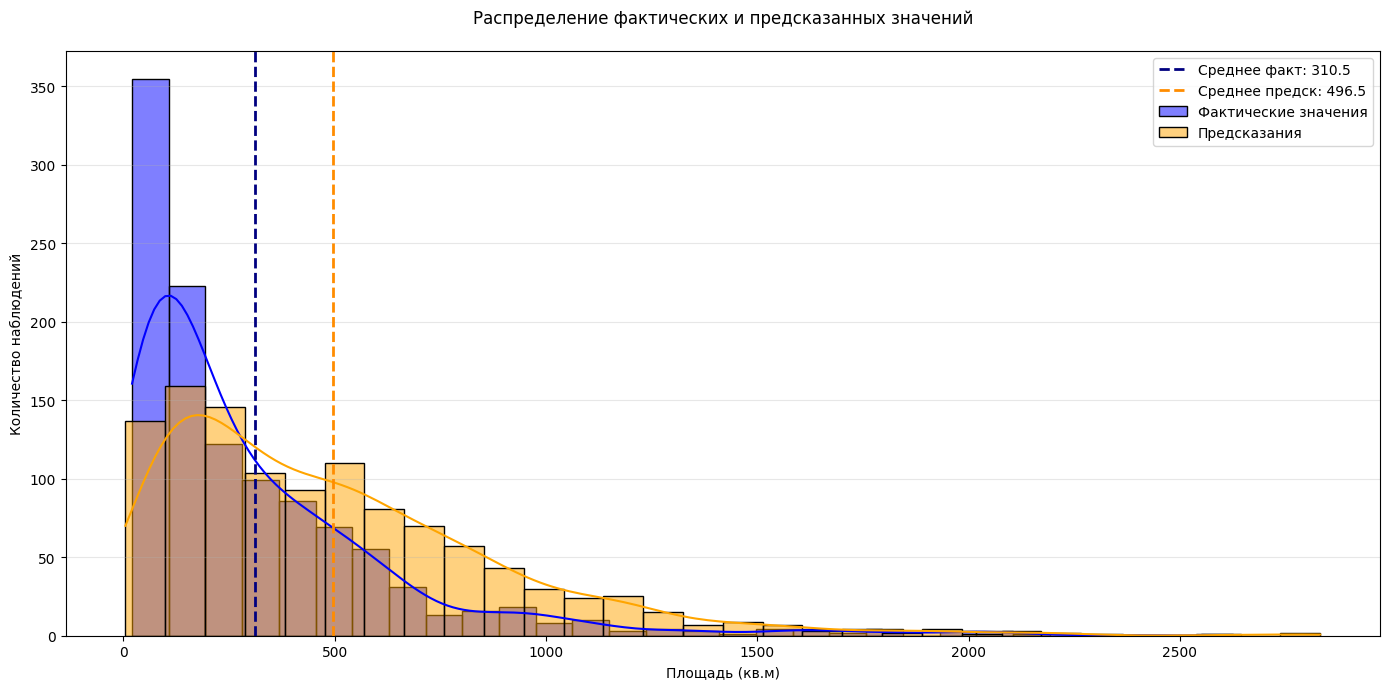

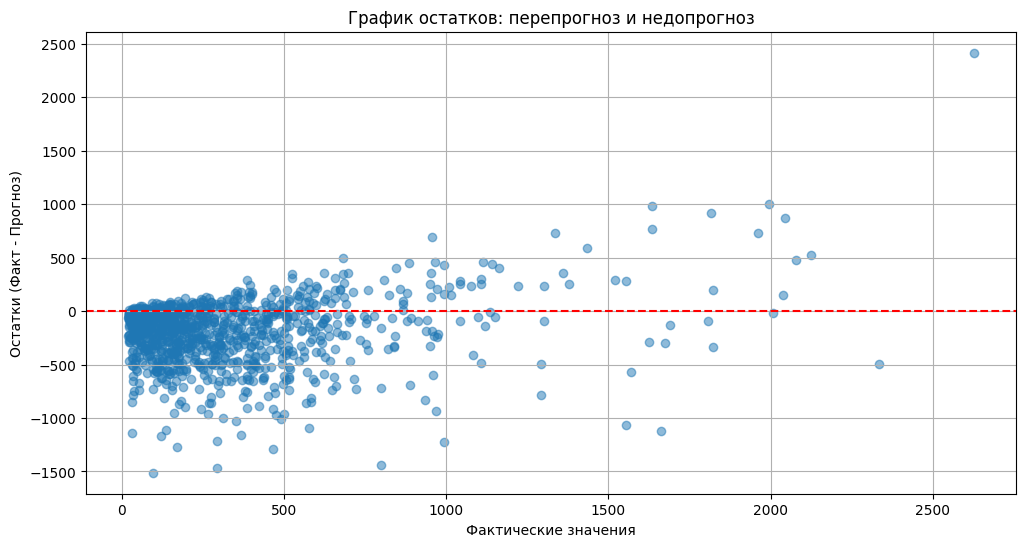

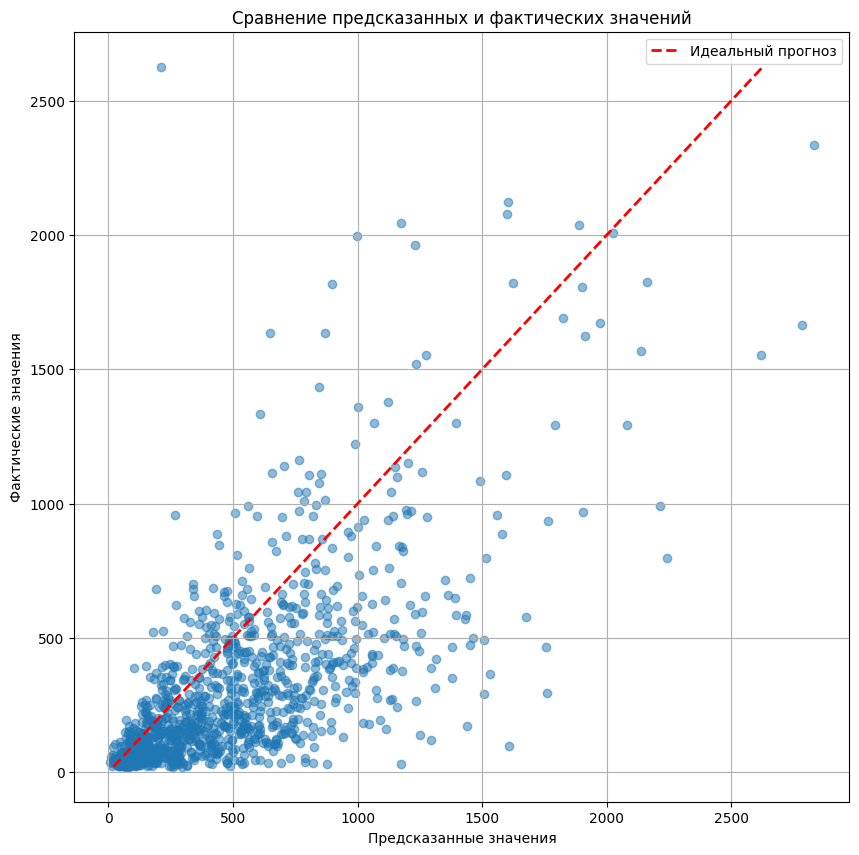

In [ ]:
# 1. –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–∞—Ä–≥–µ—Ç–∞ –∏ –ø—Ä–µ–¥–∏–∫—Ç–æ–≤
plt.figure(figsize=(14, 7))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è', kde=True, ax=ax)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ —Ñ–∞–∫—Ç: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ –ø—Ä–µ–¥—Å–∫: {test_pred.mean():.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π', pad=20)
plt.xlabel('–ü–ª–æ—â–∞–¥—å (–∫–≤.–º)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. –ì—Ä–∞—Ñ–∏–∫ –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑–∞/–Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑–∞
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –æ—Å—Ç–∞—Ç–∫–æ–≤: –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑ –∏ –Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑')
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–û—Å—Ç–∞—Ç–∫–∏ (–§–∞–∫—Ç - –ü—Ä–æ–≥–Ω–æ–∑)')
plt.grid()
plt.show()

# 3. –°–∫—ç—Ç—Ç–µ—Ä–ø–ª–æ—Ç —Å –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–æ–π –ª–∏–Ω–∏–µ–π
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='–ò–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∏ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.legend()
plt.grid()
plt.show()

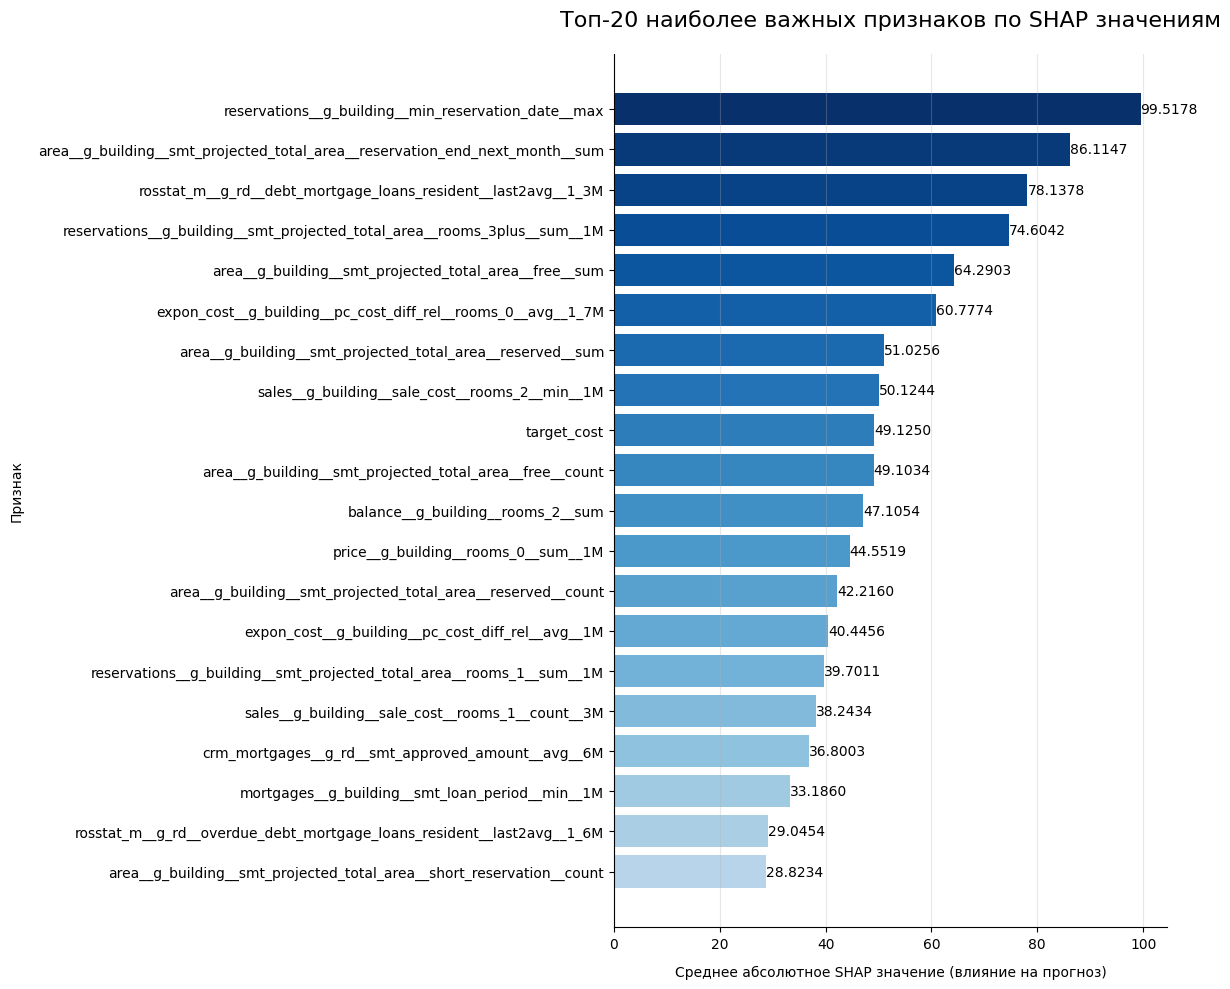

In [29]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏ —Ä–∞—Å—á–µ—Ç SHAP –∑–Ω–∞—á–µ–Ω–∏–π
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –≤–∞–∂–Ω–æ—Å—Ç—å—é —Ñ–∏—á
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# –°—Ç–∏–ª–∏–∑–∞—Ü–∏—è –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(12, 10))

# –ì–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω—ã–π bar plot —Å —Ü–≤–µ—Ç–æ–≤–æ–π –≥—Ä–∞–¥–∞—Ü–∏–µ–π
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# –î–æ–±–∞–≤–ª—è–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≤–Ω–µ—à–Ω–µ–≥–æ –≤–∏–¥–∞
plt.title('–¢–æ–ø-20 –Ω–∞–∏–±–æ–ª–µ–µ –≤–∞–∂–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ SHAP –∑–Ω–∞—á–µ–Ω–∏—è–º', pad=20, fontsize=16)
plt.xlabel('–°—Ä–µ–¥–Ω–µ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ SHAP –∑–Ω–∞—á–µ–Ω–∏–µ (–≤–ª–∏—è–Ω–∏–µ –Ω–∞ –ø—Ä–æ–≥–Ω–æ–∑)', labelpad=10)
plt.ylabel('–ü—Ä–∏–∑–Ω–∞–∫', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


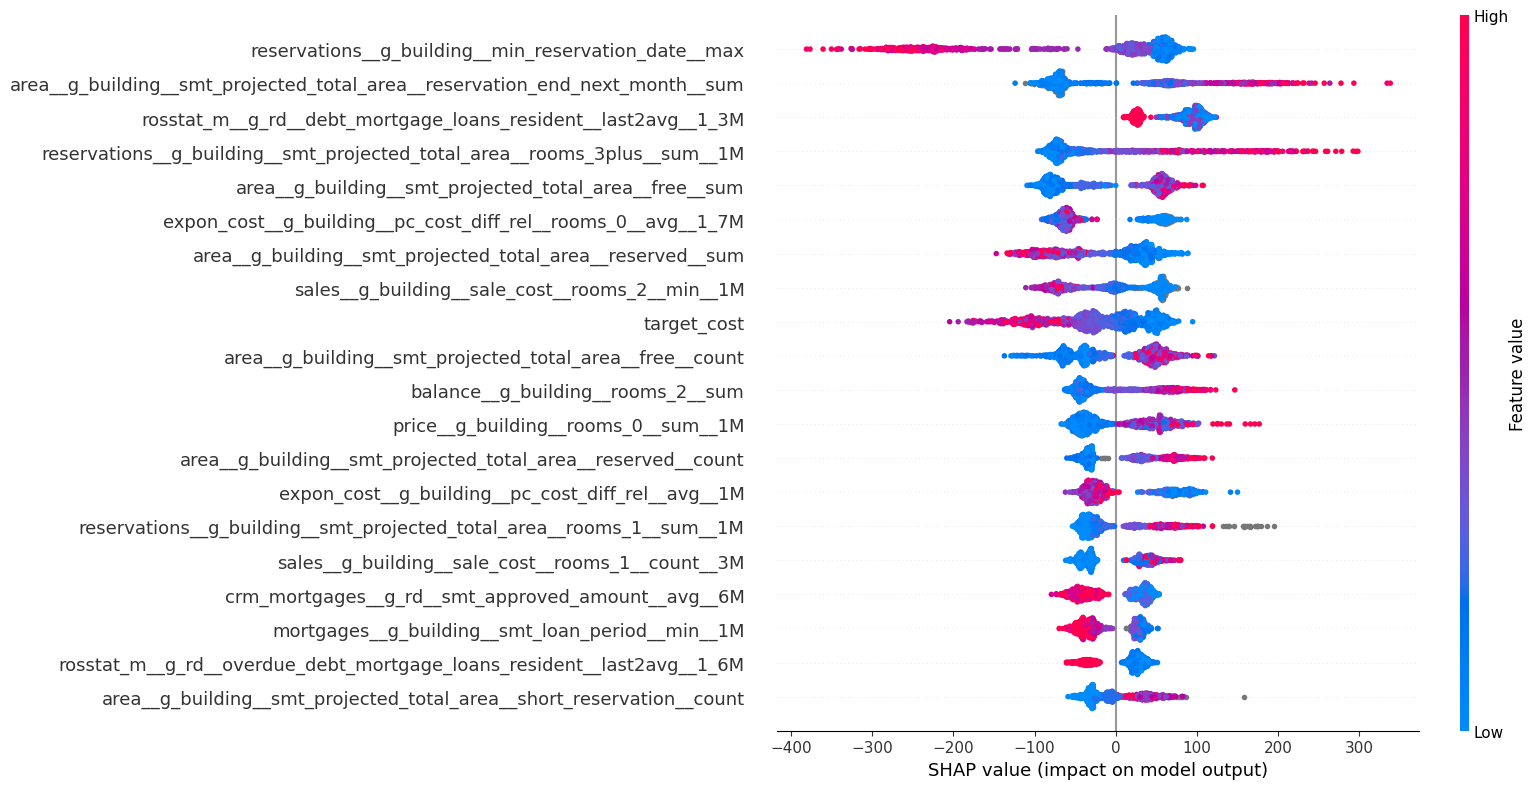

In [28]:
shap_gr(model, X_test)

# OPTUNA

In [30]:
# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', target_])
y_test = test_data[target_]

# –î–µ–ª–∏–º —á–∞—Å—Ç—å train –Ω–∞ train/valid –¥–ª—è Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# –î–ª—è CatBoost –Ω—É–∂–Ω–æ —É–∫–∞–∑—ã–≤–∞—Ç—å cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# –£–ª—É—á—à–µ–Ω–Ω–∞—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —á–µ—Ä–µ–∑ Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # –î–æ–±–∞–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–∏–ø–∞ –±—É—Ç—Å—Ç—Ä–∞–ø–∞
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# –£–ª—É—á—à–µ–Ω–Ω—ã–π –∑–∞–ø—É—Å–∫ Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=30)  

print("–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# –û–±—É—á–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# –£–¥–∞–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ –Ω—É–∂–Ω—ã –≤ —Ñ–∏–Ω–∞–ª—å–Ω–æ–π –º–æ–¥–µ–ª–∏
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# –°–æ–∑–¥–∞–µ–º DataFrame —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
metrics_df_optuna = metrics_df

[I 2025-05-15 11:33:50,123] A new study created in memory with name: no-name-3ded1694-f074-4319-a937-656f87b26016
[I 2025-05-15 11:33:53,206] Trial 0 finished with value: 185.78065267468918 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 185.78065267468918.
[I 2025-05-15 11:33:55,033] Trial 1 finished with value: 199.9046404110498 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 185.78065267468918.
[I 2025-05-15 11:33:57,524] Trial 2 

–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:
iterations: 1636
depth: 7
learning_rate: 0.03699191530070529
l2_leaf_reg: 0.005179846118033752
random_strength: 2.4204873704427543
border_count: 53
min_data_in_leaf: 59
grow_policy: Depthwise
bootstrap_type: MVS
0:	learn: 355.3327696	total: 4.18ms	remaining: 4.17s
100:	learn: 185.4973885	total: 392ms	remaining: 3.49s
200:	learn: 164.2055738	total: 723ms	remaining: 2.88s
300:	learn: 145.8824812	total: 1.03s	remaining: 2.39s
400:	learn: 131.5106891	total: 1.32s	remaining: 1.97s
500:	learn: 121.8534104	total: 1.61s	remaining: 1.6s
600:	learn: 115.0015597	total: 1.9s	remaining: 1.26s
700:	learn: 109.4162310	total: 2.18s	remaining: 931ms
800:	learn: 105.1506101	total: 2.47s	remaining: 614ms
900:	learn: 101.7428303	total: 2.76s	remaining: 303ms
999:	learn: 99.0545935	total: 3.04s	remaining: 0us


In [31]:
metrics_df_optuna

dataset         MAE            MSE        RMSE      MAPE      WAPE  \
0   train   99.054595   36166.529336  190.174997  0.334424  0.189720   
1    test  222.250814  105977.782363  325.542290  1.509482  0.715763   

         R2  mean_target   mean_pred  n_samples  
0  0.878299   522.109088  494.161024       5961  
1  0.093790   310.508982  468.664377       1139

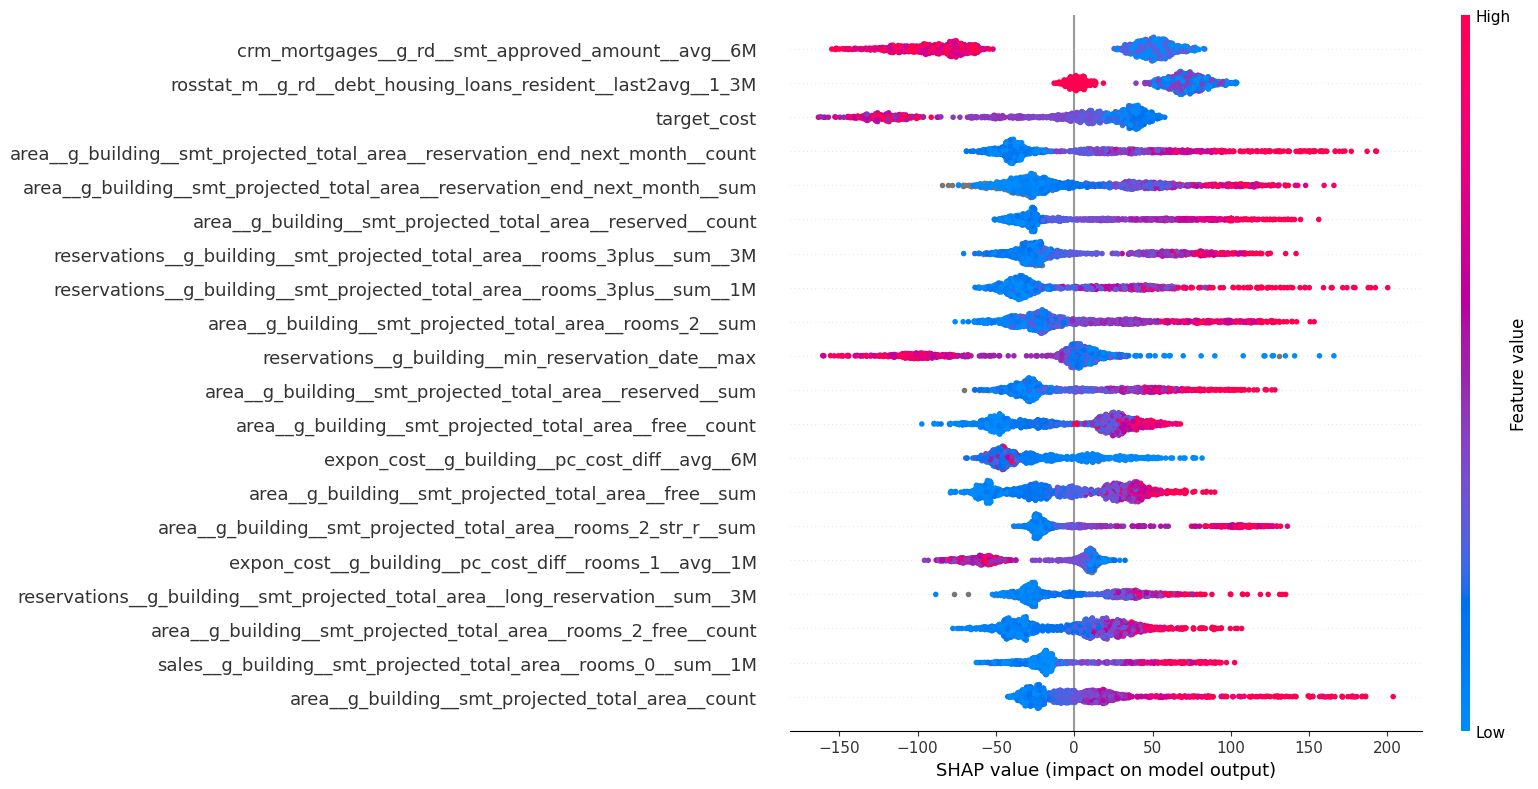

In [32]:
shap_gr(final_model, X_test)

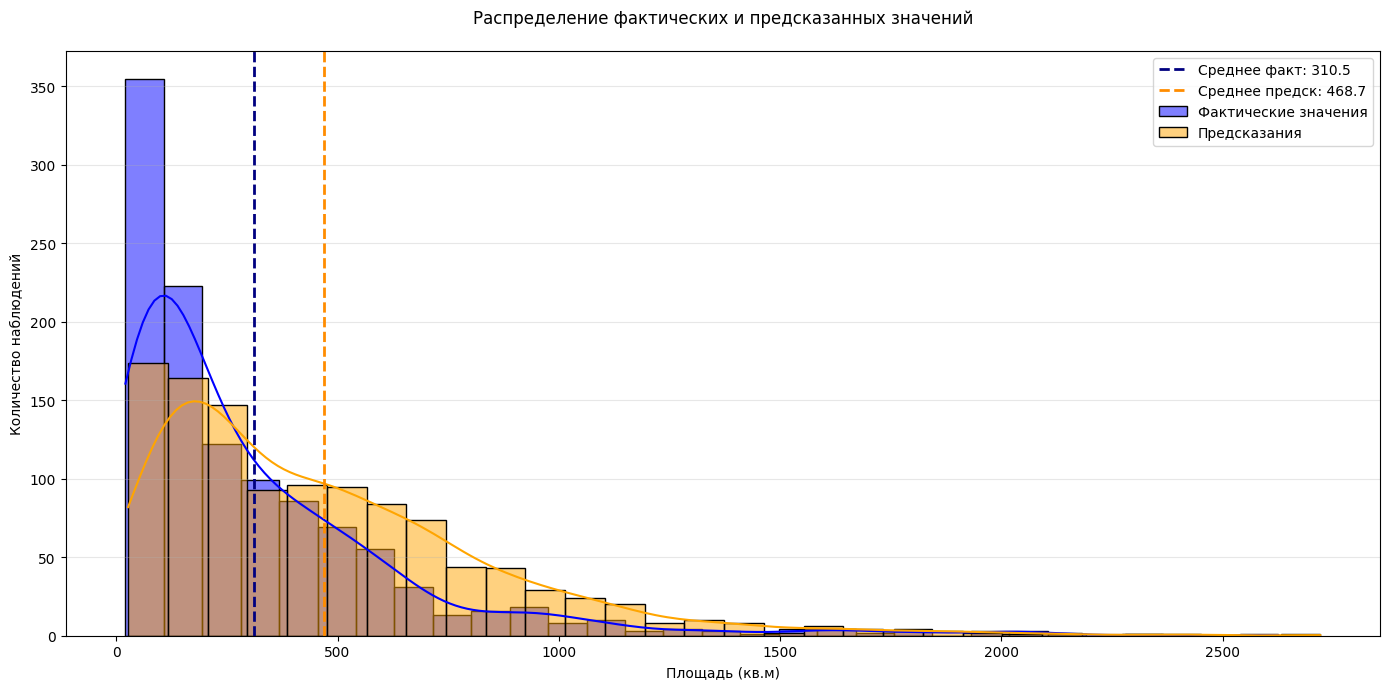

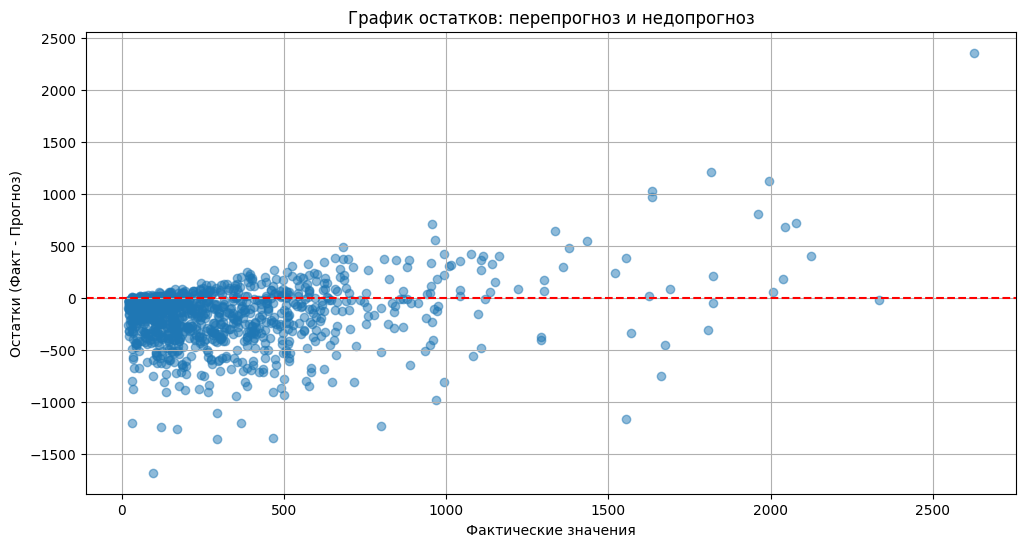

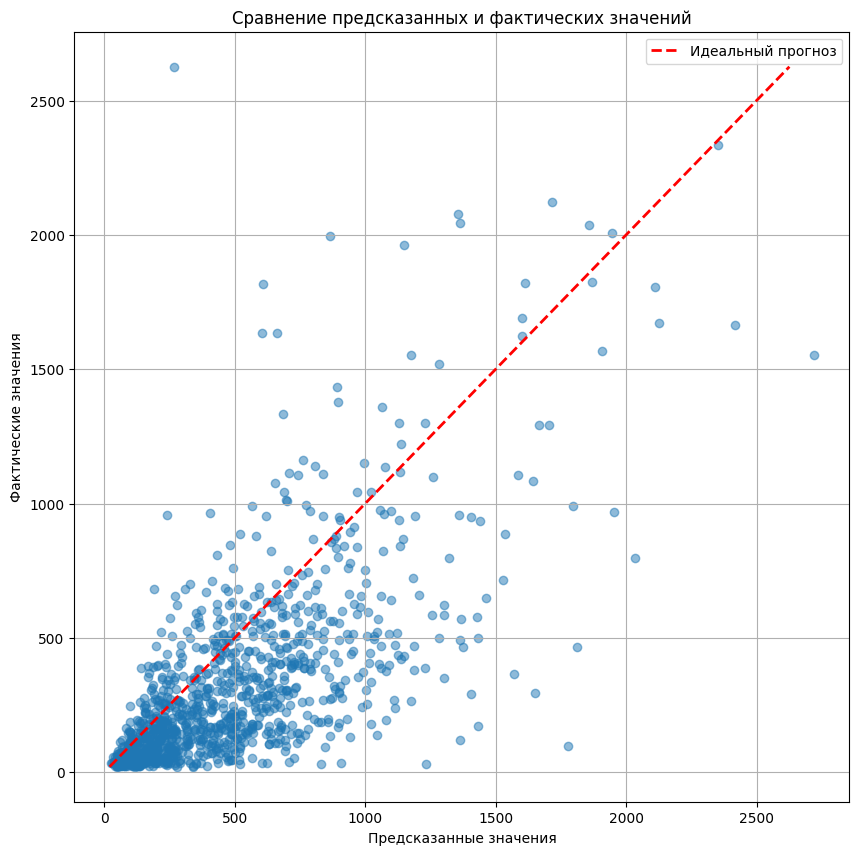

In [36]:
# 1. –ê–Ω–∞–ª–∏–∑ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–∞—Ä–≥–µ—Ç–∞ –∏ –ø—Ä–µ–¥–∏–∫—Ç–æ–≤
plt.figure(figsize=(14, 7))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è', kde=True, ax=ax)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ —Ñ–∞–∫—Ç: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'–°—Ä–µ–¥–Ω–µ–µ –ø—Ä–µ–¥—Å–∫: {test_pred.mean():.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π', pad=20)
plt.xlabel('–ü–ª–æ—â–∞–¥—å (–∫–≤.–º)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. –ì—Ä–∞—Ñ–∏–∫ –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑–∞/–Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑–∞
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –æ—Å—Ç–∞—Ç–∫–æ–≤: –ø–µ—Ä–µ–ø—Ä–æ–≥–Ω–æ–∑ –∏ –Ω–µ–¥–æ–ø—Ä–æ–≥–Ω–æ–∑')
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–û—Å—Ç–∞—Ç–∫–∏ (–§–∞–∫—Ç - –ü—Ä–æ–≥–Ω–æ–∑)')
plt.grid()
plt.show()

# 3. –°–∫—ç—Ç—Ç–µ—Ä–ø–ª–æ—Ç —Å –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–æ–π –ª–∏–Ω–∏–µ–π
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='–ò–¥–µ–∞–ª—å–Ω—ã–π –ø—Ä–æ–≥–Ω–æ–∑')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã—Ö –∏ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π')
plt.xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.legend()
plt.grid()
plt.show()


In [37]:
metrics_df_base.insert(0, 'stage', '–ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å')
metrics_df_with_select_features.insert(0, 'stage', '–ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤')
metrics_df_optuna.insert(0, 'stage', '–û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)')

In [39]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

stage dataset         MAE            MSE  \
0                    –ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å   train   34.759269    8201.279834   
1                    –ë–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å    test  230.577459  114544.673654   
2        –ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤   train   62.713844   19189.622980   
3        –ú–æ–¥–µ–ª—å —Å –æ—Ç–±–æ—Ä–æ–º –ø—Ä–∏–∑–Ω–∞–∫–æ–≤    test  246.918558  124545.101319   
4  –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)   train   99.054595   36166.529336   
5  –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)    test  222.250814  105977.782363   

         RMSE      MAPE      WAPE        R2  mean_target   mean_pred  \
0   90.560918  0.112690  0.066575  0.972402   522.109088  508.796277   
1  338.444491  1.587632  0.742579  0.020535   310.508982  463.019817   
2  138.526615  0.221215  0.120116  0.935426   522.109088  501.790822   
3  352.909480  1.658229  0.795206 -0.064978   310.508982  496.470918   
4  190.174997  0.334424  0.189720  0.878299   522.109088  494.161024   
5  325.542290  1.509482  0.715763  0.093790   310.508982  468.664377   

   n_samples  
0       5961  
1       1139  
2       5961  
3       1139  
4       5961  
5       1139

In [ ]:
X_test_modified = X_test.copy()

all_metrics = []

# –¶–∏–∫–ª –ø–æ alpha 
for alpha in np.arange(-0.1, 0.101, 0.01):
    X_test_modified['target_cost'] = X_test['target_cost'] * (1 + alpha)

    # –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ 
    test_pred = final_model.predict(X_test_modified)
    
    # –º–µ—Ç—Ä–∏–∫–∏
    metrics = calculate_metrics(y_test, test_pred, f'alpha_{alpha:.2f}')
    metrics['alpha'] = alpha  
    
    all_metrics.append(metrics)


metrics_df = pd.DataFrame(all_metrics)

# –ü–µ—Ä–µ—É–ø–æ—Ä—è–¥–æ—á–∏–≤–∞–µ–º —Å—Ç–æ–ª–±—Ü—ã, —á—Ç–æ–±—ã alpha –±—ã–ª –ø–µ—Ä–≤—ã–º
cols = ['alpha'] + [col for col in metrics_df.columns if col != 'alpha']
metrics_df = metrics_df[cols]

pd.concat([result[-1:],metrics_df], ignore_index=True)

stage      dataset         MAE            MSE  \
0   –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å (Optuna)         test  222.250814  105977.782363   
1                                NaN  alpha_-0.10  227.461714  109123.280498   
2                                NaN  alpha_-0.09  227.044822  108883.489172   
3                                NaN  alpha_-0.08  226.522835  108538.989646   
4                                NaN  alpha_-0.07  226.093428  108240.491162   
5                                NaN  alpha_-0.06  225.482735  107847.723564   
6                                NaN  alpha_-0.05  224.946536  107546.277463   
7                                NaN  alpha_-0.04  224.332857  107180.971441   
8                                NaN  alpha_-0.03  223.782169  106819.704063   
9                                NaN  alpha_-0.02  223.330154  106563.787067   
10                               NaN  alpha_-0.01  222.793473  106277.986696   
11                               NaN  alpha_-0.00  222.250814  105977.782363   
12                               NaN   alpha_0.01  221.747566  105678.928616   
13                               NaN   alpha_0.02  220.966481  105208.698775   
14                               NaN   alpha_0.03  220.331739  104810.627628   
15                               NaN   alpha_0.04  219.748792  104378.314228   
16                               NaN   alpha_0.05  219.166160  104062.929111   
17                               NaN   alpha_0.06  218.612590  103748.178494   
18                               NaN   alpha_0.07  217.947080  103353.587298   
19                               NaN   alpha_0.08  217.165384  102789.299004   
20                               NaN   alpha_0.09  216.655126  102479.942118   
21                               NaN   alpha_0.10  216.126563  102150.013214   

          RMSE      MAPE      WAPE        R2  mean_target   mean_pred  \
0   325.542290  1.509482  0.715763  0.093790   310.508982  468.664377   
1   330.338131  1.575996  0.732545  0.066893   310.508982  476.042231   
2   329.974983  1.570311  0.731202  0.068944   310.508982  475.456534   
3   329.452561  1.562283  0.729521  0.071890   310.508982  474.833098   
4   328.999227  1.557021  0.728138  0.074442   310.508982  474.208268   
5   328.401772  1.548282  0.726171  0.077801   310.508982  473.445344   
6   327.942491  1.542441  0.724445  0.080378   310.508982  472.702224   
7   327.385051  1.533942  0.722468  0.083502   310.508982  471.852162   
8   326.832838  1.527684  0.720695  0.086591   310.508982  471.034481   
9   326.441093  1.522190  0.719239  0.088779   310.508982  470.250494   
10  326.003047  1.515421  0.717511  0.091223   310.508982  469.436657   
11  325.542290  1.509482  0.715763  0.093790   310.508982  468.664377   
12  325.082957  1.502682  0.714142  0.096346   310.508982  467.860320   
13  324.358904  1.494014  0.711627  0.100367   310.508982  466.830343   
14  323.744695  1.487638  0.709582  0.103771   310.508982  465.833779   
15  323.076329  1.481732  0.707705  0.107467   310.508982  464.846536   
16  322.587863  1.475348  0.705829  0.110164   310.508982  463.821380   
17  322.099641  1.468892  0.704046  0.112856   310.508982  462.917595   
18  321.486527  1.462048  0.701903  0.116230   310.508982  461.729269   
19  320.607703  1.455339  0.699385  0.121055   310.508982  460.459875   
20  320.124885  1.450022  0.697742  0.123700   310.508982  459.444319   
21  319.609157  1.442311  0.696040  0.126521   310.508982  458.314317   

    n_samples         alpha  
0        1139           NaN  
1        1139 -1.000000e-01  
2        1139 -9.000000e-02  
3        1139 -8.000000e-02  
4        1139 -7.000000e-02  
5        1139 -6.000000e-02  
6        1139 -5.000000e-02  
7        1139 -4.000000e-02  
8        1139 -3.000000e-02  
9        1139 -2.000000e-02  
10       1139 -1.000000e-02  
11       1139 -5.551115e-17  
12       1139  1.000000e-02  
13       1139  2.000000e-02  
14       1139  3.000000e-02  
15      

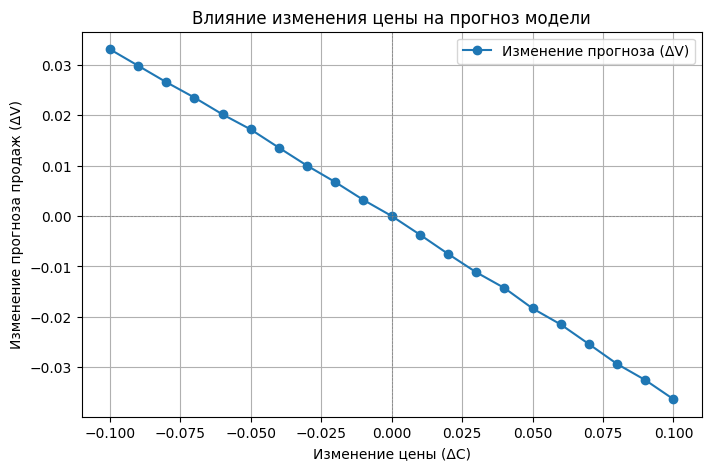

In [ ]:
V_pred_0 = final_model.predict(X_test)
results = []


for alpha in np.arange(-0.1, 0.101, 0.01):
    # –ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä—É–µ–º target_cost
    X_test_modified = X_test.copy()
    X_test_modified['target_cost'] = X_test['target_cost'] * (1 + alpha)
    
    # –ü—Ä–æ–≥–Ω–æ–∑–∏—Ä—É–µ–º —Å –∏–∑–º–µ–Ω—ë–Ω–Ω—ã–º target_cost
    V_pred_modified = final_model.predict(X_test_modified)
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º ŒîV –∏ ŒîC
    delta_V = (V_pred_modified - V_pred_0) / V_pred_0
    delta_C = alpha  # –ø–æ—Å–∫–æ–ª—å–∫—É C_modified = C_0 * (1 + alpha)
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
    results.append({
        'alpha': alpha,
        'delta_C': delta_C,
        'delta_V': delta_V  # –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è (–¥–ª—è –≥—Ä–∞—Ñ–∏–∫–∞)
    })

# 3. –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
results_df = pd.DataFrame(results)

# –ì—Ä–∞—Ñ–∏–∫: —Ç–æ–ª—å–∫–æ —Å—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è delta_V
plt.figure(figsize=(8, 5))
plt.plot(
    results_df['delta_C'],
    results_df['delta_V_mean'],
    'o-',  # —Ç–æ—á–∫–∏ + –ª–∏–Ω–∏—è
    label='–ò–∑–º–µ–Ω–µ–Ω–∏–µ –ø—Ä–æ–≥–Ω–æ–∑–∞ (ŒîV)'
)

# –†–∞–∑–º–µ—Ç–∫–∞
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('–ò–∑–º–µ–Ω–µ–Ω–∏–µ —Ü–µ–Ω—ã (ŒîC)')
plt.ylabel('–ò–∑–º–µ–Ω–µ–Ω–∏–µ –ø—Ä–æ–≥–Ω–æ–∑–∞ –ø—Ä–æ–¥–∞–∂ (ŒîV)')
plt.title('–í–ª–∏—è–Ω–∏–µ –∏–∑–º–µ–Ω–µ–Ω–∏—è —Ü–µ–Ω—ã –Ω–∞ –ø—Ä–æ–≥–Ω–æ–∑ –º–æ–¥–µ–ª–∏')
plt.legend()
plt.grid(True)
plt.show()